In [6]:
import sys,json
import pandas as pd
import os
import ipywidgets as widgets
while 'configs' not in os.listdir('.'):
    os.chdir('../')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from torch.optim import Adam, SGD
from torch.nn import BCELoss, CrossEntropyLoss

# Set the directory path
RESULTS_ROOT = './results/'

# Get the list of files in the directory


from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
img_transform = transforms.Compose([ transforms.ToTensor()])
# transform for mask
msk_transform = transforms.Compose([transforms.ToTensor()])
msk_transform = torch.tensor
from sklearn.metrics import multilabel_confusion_matrix
import random
from PIL import Image
import cv2

from adaptive_mis.common import load_config,loader


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {device}")
def get_model(model_dir,fold):
    
    torch.cuda.empty_cache()
    best_model = best_model.to(device)

    fn = "best_model_state_dict.pt"
    model_path = f"{model_dir}/{fold}/{fn}"

    best_model.load_state_dict(torch.load(model_path))
    result_file_path = f"{model_dir}/{fold}/result.json"
    with open(result_file_path, 'r') as f:
        results = json.loads(''.join(f.readlines()))
    best = results['best_result']

    print(f"{model_dir.split('/')[-1]} Loaded best model weights... best loss: tr:{best['tr_loss']:0.5f} val:{best['vl_loss']:0.5f}")
    return best_model
def get_metrics():
    
    params = {}
    return torchmetrics.MetricCollection(
        [
            torchmetrics.F1Score(**params),
            torchmetrics.Accuracy(**{**params, 'average': 'micro'}),
            torchmetrics.Dice(**params),
            torchmetrics.Precision(**params),
            torchmetrics.Specificity(**params),
            torchmetrics.Recall(**params),
            # IoU
            torchmetrics.JaccardIndex(**{**params, 'num_classes': 2})
        ],
        prefix='',

    )
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import ipyplot,random
@widgets.interact
def datasets(dataset=sorted(os.listdir(RESULTS_ROOT))):
        # ipyplot.plot_images(debug_imgs, max_images=4, img_width=150)
        ROOT=f'{RESULTS_ROOT}/{dataset}'
        runns = sorted(os.listdir(ROOT, key=lambda x: os.path.getmtime(os.path.join(f'{RESULTS_ROOT}/{dataset}', x)), reverse=True))

        @widgets.interact_manual
        def compare(dirs=widgets.SelectMultiple(options=runns, description='Runns',           layout=widgets.Layout(width='100%', height='180px')),titles="comma seperated"):
            allmetrics={}
            models={}
            display_names={} 
            
            for i,d in enumerate(dirs):
                try:
                    date=d.split('_')[-1]
                    if len(titles.split(','))==len(dirs):
                        display_names[d]= titles.split(',')[i]
                    else:
                        display_names[d]=d.replace(dataset+"_",'').replace("_"+date,'')
                        
                        
                    
                    models[d]=model=get_model(f'{ROOT}/{d}')
                    with open(f'{ROOT}/{d}/test_final_result.json', 'r') as f:
                        results = json.load(f)
                    allmetrics[d] = {k.split('/')[-1]:v for k,v in results.items()}
                    allmetrics[d]['model']=display_names[d]
                    allmetrics[d]['date']=date
                except Exception as e:
                    print(f"skip {d} due to error-->{e}")
            df=pd.DataFrame(allmetrics).T.sort_values('final_JaccardIndex', ascending=False)
            pd.set_option('display.max_rows', None)

            display(df)
            df=df.groupby(['model']).agg({'final_Accuracy':['mean','std'],'final_Dice':['mean','std'],'final_JaccardIndex':['mean','std','count']}).sort_values(('final_JaccardIndex','mean'), ascending=False)
            df=df.round(4)
            display(df)
            df=df.astype(str)
            df['Accuracy']=df[('final_Accuracy','mean')] +"±"+ df[('final_Accuracy','std')]
            df['Dice']=df[('final_Dice','mean')] +"±"+ df[('final_Dice','std')]
            df['IoU']=df[('final_JaccardIndex','mean')] +"±"+ df[('final_JaccardIndex','std')]
            display(df[['Accuracy','Dice','IoU']])
            print(df[['Accuracy','Dice','IoU']].to_latex()) #.replace('±','\pm'))
            @widgets.interact
            def select_case(image_number=widgets.IntSlider(0,0,len(te_dataset))):
                item=te_dataset[image_number]
                img,msk=item['image'].cpu().numpy().astype('float32'),item['mask'].cpu().numpy().astype('float32')
                imgv=img=np.transpose(img,(1, 2, 0))
                if img.shape[-1]==4:
                    imgv=img[...,:-1]

                nonzero = np.where(imgv != 0)
                roi=np.zeros((imgv.ndim,2))
                for i in range(len(nonzero)):
                    if len(nonzero[i]) > 0:
                        roi[i][0] = max(0, nonzero[i].min())
                        roi[i][1] = min( imgv.shape[i], nonzero[i].max() + 1)

                # print(img.shape)
                # debug_imgs=[img]
                added=(img[...,-1]>0)*dataset.startswith('segpc')*.1
                # plt.imshow(imgs[image_number][:,:,:-1])
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                fig, axs = plt.subplots(1, len(models)+2, sharex=True, sharey=True)
                fig.set_size_inches(1000/80, fig.get_figheight())

                axs[0].imshow(imgv)
                # axs[0].set_xlim(roi[1][0], roi[1][1])
                # axs[0].set_ylim(roi[0][0], roi[0][1])
                axs[1].set_title('GT')
                plt.axis('off')
                for i in range(len(axs)):
                    axs[i].axis('off')
                torch_msk=torch.stack([torch.tensor(msk).to(device)])
                msk=np.argmax(msk,0)
                axs[1].imshow(msk+added, cmap='gist_stern')
                torch_img=torch.stack([transforms.ToTensor()(img).to(device)])
                
                
                
                msks_ = torch.argmax(torch_msk, 1, keepdim=False)
                tmpres={}
                for i,d in enumerate(models):
                    preds=models[d](torch_img)
                    preds_ = torch.argmax(preds, 1, keepdim=False).float()
                    pred=preds.detach().cpu().numpy()[0][1,...]
                    pred=pred>0.5
                    # print(pred.shape,msk.shape,pred.max(),msk.max(),pred.min(),msk.min())
                    
                    # print(pred.max())
                    axs[i+2].imshow(pred+added, cmap='gist_stern')
                    axs[i+2].set_title(display_names[d])
                    metrics=get_metrics().to(device)
                    metrics.update(preds_, msks_)
                    
                    # cm = confusion_matrix(msk.reshape(-1), pred.reshape(-1),)
                    # print(display_names[d])
                    
                    tmpres[d]={k: float(v.cpu().numpy()) for k, v in metrics.compute().items()}
                    
                    # with open(f'{directory}/{d}/result.json', 'r') as f:
                    #     results = json.load(f)
                    # allmetrics[display_name] = {k.split('/')[-1]:v for k,v in results['best_result']['te_metrics'].items()}
                    # del models[d]
                # print(tmpres)
                plt.tight_layout()
                plt.show()  
                display("Only Current Image")
                display(pd.DataFrame(tmpres).T.round(4).sort_values('JaccardIndex', ascending=False))

                

#isic2018 --> 61

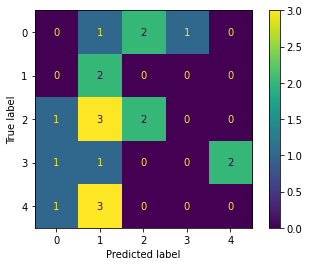

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from torch import randint
from torchmetrics import F1Score
from torchmetrics.classification import ConfusionMatrix
metric = ConfusionMatrix(num_classes=5)
metric.update(randint(5, (20,)), randint(5, (20,)))
ConfusionMatrixDisplay(metric.compute().numpy()).plot()

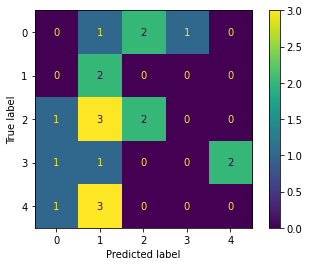

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from torch import randint
from torchmetrics import F1Score
from torchmetrics.classification import ConfusionMatrix
metric = ConfusionMatrix(num_classes=5)
metric.update(randint(5, (20,)), randint(5, (20,)))
ConfusionMatrixDisplay(metric.compute().numpy()).plot()

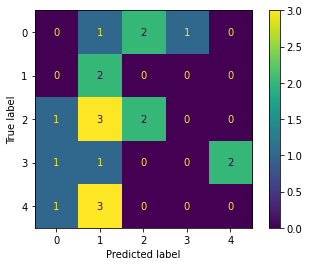

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from torch import randint
from torchmetrics import F1Score
from torchmetrics.classification import ConfusionMatrix
metric = ConfusionMatrix(num_classes=5)
metric.update(randint(5, (20,)), randint(5, (20,)))
ConfusionMatrixDisplay(metric.compute().numpy()).plot()

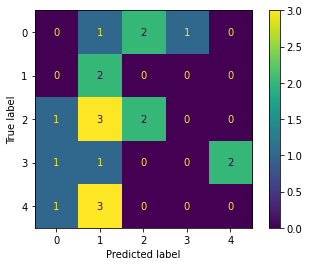

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from torch import randint
from torchmetrics import F1Score
from torchmetrics.classification import ConfusionMatrix
metric = ConfusionMatrix(num_classes=5)
metric.update(randint(5, (20,)), randint(5, (20,)))
ConfusionMatrixDisplay(metric.compute().numpy()).plot()